## Importing Guide

In [1]:
# Importing required python packages
import pybullet as p
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os

# Importing required Super Mario Bros packages
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace

# Importing required directory packages for the models
from ReinforcementLearning import ReinforcementLearning
from Wrappers import apply_wrappers

pybullet build time: Nov 28 2023 23:45:17


## Hyperparmaters

In [2]:
DISPLAY = True                  # Sets the environment render mode to human or rgb_array
EPISODES = 10000                # Number of episodes to train the AI on
MEM_SIZE = 100000               # Size of the memory in replay buffer
REPLAY_START_SIZE = 1000        # Amount of samples to fill the replay buffer before training
NETWORK_UPDATE_ITER = 1000      # Number of iterations before learning func updates the Q weights

MEM_RETAIN = 0.1                # Size of memory that cannot be overwritten (avoids catastrophic forgetting)
BATCH_SIZE = 32                 # Size of random batches when sampling experiences
LEARNING_RATE = 0.00025         # Learning rate for optimizing neural network weights
GAMMA = 0.9                     # Discount factor for future rewards
EPSILON_START = 1.0             # Starting exploration rate
EPSILON_END = 0.1               # Ending exploration rate
EPSILON_DECAY = 0.99999975      # Rate at which exploration rate decays

DQN_DIM1 = 512                  # Number of neurons in DQN's first hidden layer
DQN_DIM2 = 512                  # Number of neurons in DQN's second hidden layer

## Training the AI

Using CUDA device:  NVIDIA RTX A2000 Laptop GPU


/home/blakemuchmorewsl/git/SuperMarioBros.github.io/.venv/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/blakemuchmorewsl/git/SuperMarioBros.github.io/.venv/lib/python3.10/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


Epsiode:  0  Reward:  20.0
Epsiode:  1  Reward:  434.0
Epsiode:  2  Reward:  244.0
Epsiode:  3  Reward:  250.0
Epsiode:  4  Reward:  235.0
Epsiode:  5  Reward:  248.0
Epsiode:  6  Reward:  250.0
Epsiode:  7  Reward:  248.0
Epsiode:  8  Reward:  250.0
Epsiode:  9  Reward:  581.0
Number of successful episodes:  0


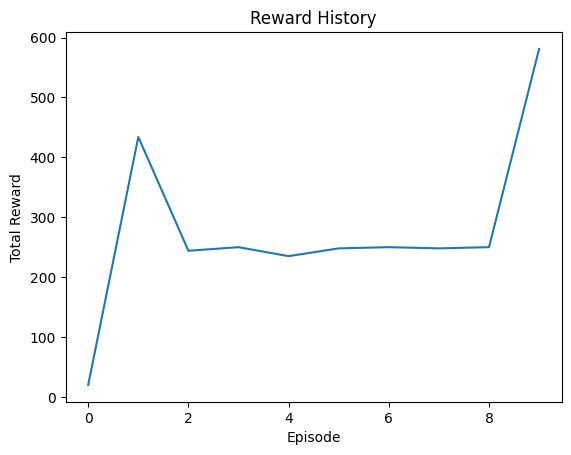

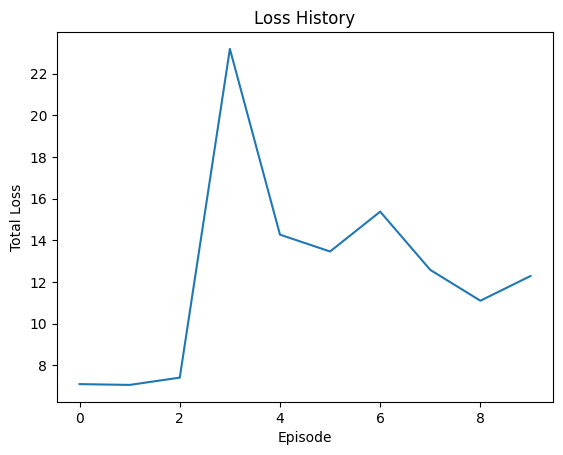

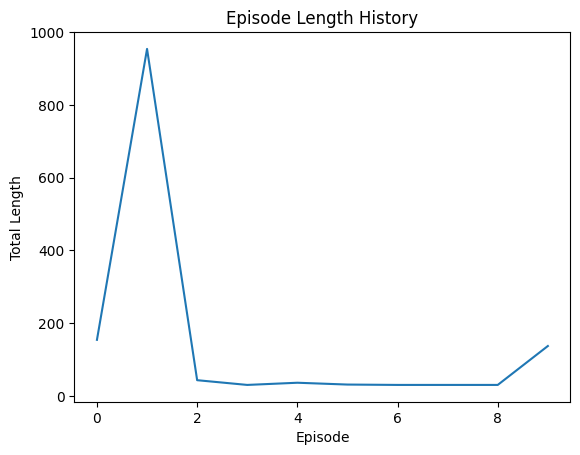

In [4]:
# Creating variables to store evaluation metrics
episode_history = []
episode_reward_history = []
episode_loss_history = []
episode_length_history = []
episode_batch_score = 0
episode_reward = 0
episode_batch_loss = 0
episode_length = 0
successful_episodes = 0

# Setting path for saving the model policy network
save_path = os.path.join(os.getcwd(), "policy_network.pkl")

# Ensuring a CUDA GPU device is available
if torch.cuda.is_available():
    # Creating device variable and setting it to the CUDA device
    device = torch.device("cuda")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))  # Printing CUDA device name
else:
    print("CUDA GPU is not available")

# Creating the Super Mario Bros environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', render_mode='human' if DISPLAY else 'rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = apply_wrappers(env)  # Applying the custom wrapper for the environment

# Creating DQN Reinforcement Learning Agent
agent = ReinforcementLearning(env, MEM_SIZE, MEM_RETAIN, BATCH_SIZE, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, NETWORK_UPDATE_ITER, REPLAY_START_SIZE, DQN_DIM1, DQN_DIM2)

# Initialising and resetting the environment
env.reset()
state, reward, done, trunc, info = env.step(action=0)

# Looping through the episodes to train the model
for episode in range(EPISODES):
    done = False  # Setting default done state
    state, info = env.reset()  # Resetting environment and getting state

    # Running the episode until done (indicated by death or by reaching the goal)
    while not done:
        # Sampling an action to take within the environment
        action = agent.choose_action(state)
        state_, reward, done, trunc, info = env.step(action)

        # Adding the experience to the memory and checking if we should train the model
        agent.memory.add(state, action, reward, state_, done)  # Adding experience to replay buffer
        if agent.memory.memory_count >= REPLAY_START_SIZE:
            episode_loss = agent.learn()  # Updating Q-value weights of the neural network
            episode_batch_loss += episode_loss  # Updating batch loss

        state = state_  # Updating current state
        prev_info = info  # Updating previous info

        # Updating performance metrics
        if info['flag_get'] == True:
            successful_episodes += 1  # Updating successful episodes counter
        episode_reward += reward  # Updating episode reward
        episode_batch_score += reward  # Update episode score
        episode_length += 1 # Updating episode length

    # Appending episodes and rewards to the history for plotting
    print("Epsiode: ", episode, " Reward: ", episode_reward)
    episode_history.append(episode)
    episode_reward_history.append(episode_reward)
    episode_loss_history.append(episode_loss)
    episode_length_history.append(episode_length)
    episode_reward = 0  # Resetting episode reward
    episode_length = 0  # Resetting episode length

    # Saving model every batches of 100 episodes
    if episode % 100 == 0 and agent.memory.memory_count > REPLAY_START_SIZE:
        torch.save(agent.policy_network.state_dict(), save_path)
        print("Average total reward per episode batch since episode ", episode, ": ", episode_batch_score/ float(100))
        print("Average total loss per episode batch since episode ", episode, ": ", episode_batch_loss/ float(100))
        episode_batch_score = 0  # Resetting batch score for next batch
        episode_batch_loss = 0  # Resetting batch loss for next batch

print("Number of successful episodes: ", successful_episodes)

plt.figure()
plt.plot(episode_history, episode_reward_history)
plt.title('Reward History')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

plt.figure()
plt.plot(episode_history, episode_loss_history)
plt.title('Loss History')
plt.xlabel('Episode')
plt.ylabel('Total Loss')
plt.show()

plt.figure()
plt.plot(episode_history, episode_length_history)
plt.title('Episode Length History')
plt.xlabel('Episode')
plt.ylabel('Total Length')
plt.show()

env.close()

## Testing the AI

In [7]:
# Creating the Super Mario Bros environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', render_mode='human' if DISPLAY else 'rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = apply_wrappers(env)  # Applying the custom wrapper for the environment

# Creating DQN Reinforcement Learning Agent
agent = ReinforcementLearning(env, MEM_SIZE, MEM_RETAIN, BATCH_SIZE, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, NETWORK_UPDATE_ITER, REPLAY_START_SIZE, DQN_DIM1, DQN_DIM2)

# Initialising and resetting the environment
state, info = env.reset()
state, reward, done, trunc, info = env.step(action=0)

# Loading the saved model policy network
agent.policy_network.load_state_dict(torch.load("policy_network.pkl"))  # Loading policy network

frames = []  # Frames container for video
frames.append(env.render())  # Appending initial frame to video
agent.policy_network.eval()  # Setting policy network to evaluation mode

# Running the episode until done (indicated by death or by reaching the goal)
while True:
    # Getting the Q-values from the trained neural network
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.memory.device)
        q_values = agent.policy_network(state_tensor)

    # Taking steps in the environment based on the Q-values for the given state
    action = torch.argmax(q_values).item()
    state, reward, done, trunc, info = env.step(action)
    frames.append(np.copy(env.render()))  # Appending frame to video

    # Breaking the loop if the episode is done
    if done:
        break

env.close()  # Closing the environment